<a href="https://colab.research.google.com/github/rafimagdon-wq/srilankadengueanalysis/blob/main/denguedataanalyticssrilanka.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')  # Mount Google Drive

# Use your file path inside Drive
df = pd.read_csv("/content/SriLanka_dengidata_2013_2022.csv", index_col=False)
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,index,time,region,meanTair_F_Inst,minTair_F_Inst,maxTair_F_Inst,meanQair_F_Inst,meanSoilmoi0_10Cm_Inst,meanCanopint_Inst,meanPsurf_F_Inst,meanNdvi,minNdvi,maxNdvi,meanPrecipitationcal,minPrecipitationcal,maxPrecipitationcal,cases
0,0,7875.0,315.0,Ampara,302.333191,301.926086,302.702484,0.017031,25.367788,0.070869,99238.156250,0.336044,0.181286,0.500243,1.081435,0.002426,5.917336,3.0
1,1,7876.0,315.0,Anuradhapura,302.066742,301.648224,302.776428,0.017640,20.588243,0.000887,99664.914062,0.329114,0.174629,0.424814,0.031669,0.000000,0.451204,9.0
2,2,7877.0,315.0,Badulla,296.759888,290.434296,302.063751,0.015888,28.335207,0.108685,91665.226562,0.265771,0.162514,0.409743,1.006210,0.018600,2.355008,29.0
3,3,7878.0,315.0,Batticaloa,303.107391,302.881073,303.405914,0.017433,20.746124,0.040024,100180.687500,0.417131,0.307329,0.501071,0.042987,0.000000,0.689772,23.0
4,4,7879.0,315.0,Colombo,300.694458,300.045013,301.343933,0.017812,28.184500,0.110018,99863.453125,0.333495,0.221043,0.436129,8.888183,5.248857,14.715760,25.0


Detected columns:
region cases meanNdvi meanPrecipitationcal meanTair_F_Inst shapeName

Head of joined GeoDataFrame (gdfj):


,shapeName,shapeISO,shapeID,shapeGroup,shapeType,geometry,_dkey,_province,cases,ndvi,precip,temp
0,Northern Province,LK-4,99731895B93054189817547,LKA,ADM1,"MULTIPOLYGON (((79.91381 8.94183, 79.91379 8.9...",northern province,northern province,16.249160,0.293586,4.398457,300.888020
1,Eastern Province,LK-5,99731895B51072878877669,LKA,ADM1,"POLYGON ((80.75304 8.90515, 80.78104 8.91667, ...",eastern province,eastern province,28.902661,0.320842,4.796706,300.668989
2,Central Province,LK-2,99731895B28050807675820,LKA,ADM1,"POLYGON ((80.98913 7.72169, 80.98844 7.72144, ...",central province,central province,57.711134,0.314974,5.678535,297.728495
3,North Central Province,LK-7,99731895B66209916164902,LKA,ADM1,"POLYGON ((80.03237 8.52721, 80.03268 8.52444, ...",north central province,north central province,11.918067,0.327122,4.999716,300.411900
4,North Western Province,LK-6,99731895B5260290378804,LKA,ADM1,"MULTIPOLYGON (((79.77994 8.26209, 79.78165 8.2...",north western province,north western province,46.344538,0.327233,5.220957,300.344681



Correlation matrix:
            cases      ndvi    precip      temp
cases   1.000000 -0.423992  0.802197 -0.129398
ndvi   -0.423992  1.000000 -0.506111  0.249461
precip  0.802197 -0.506111  1.000000 -0.426333
temp   -0.129398  0.249461 -0.426333  1.000000


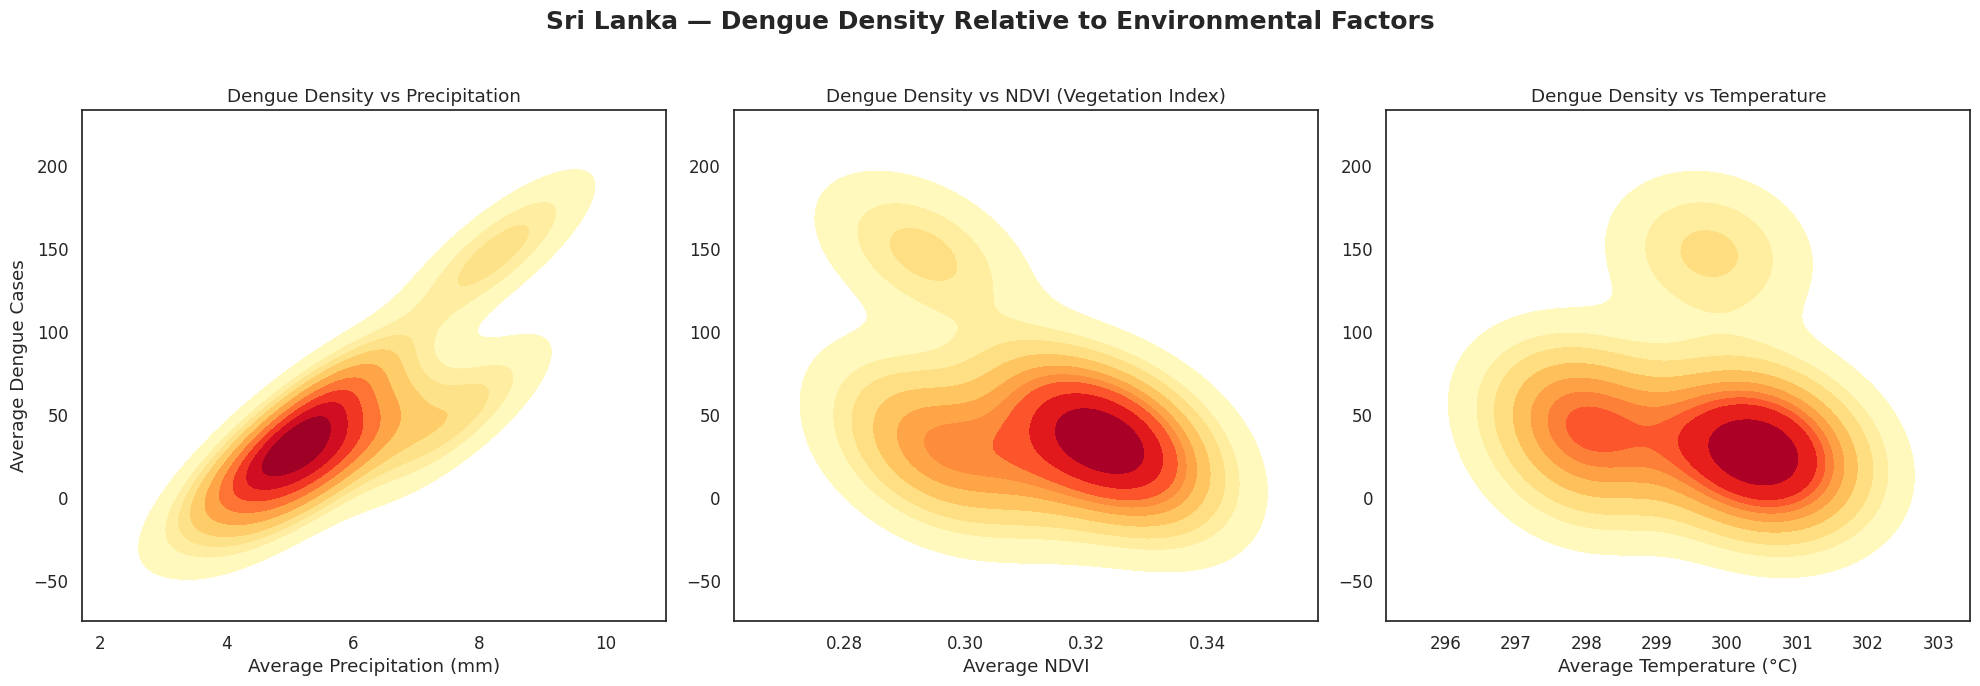

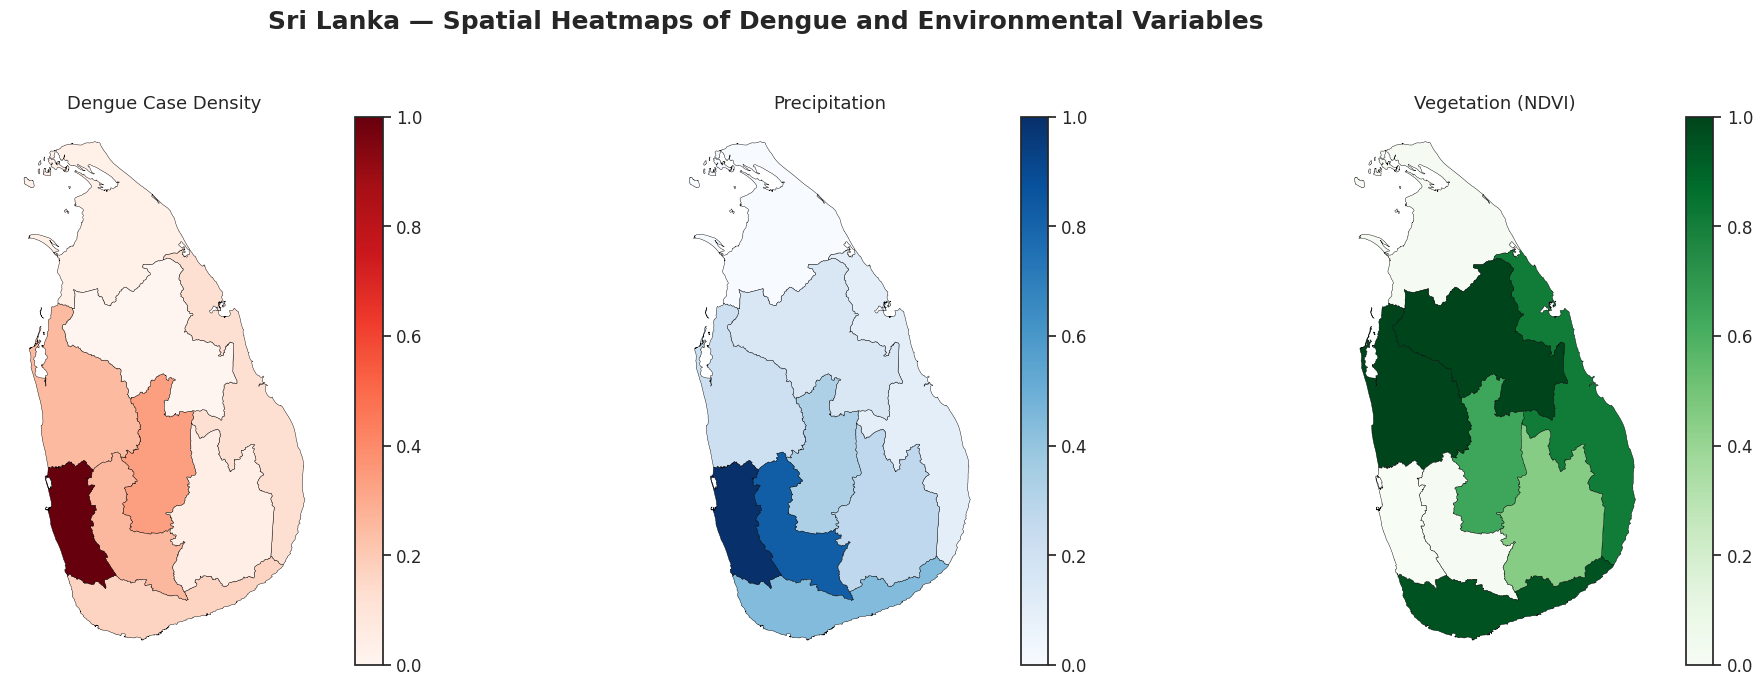

In [21]:
# ================================================================
# Sri Lanka Dengue Heatmaps vs NDVI, Precipitation, and Temperature
# ================================================================

!pip -q install geopandas pyogrio shapely pyproj rtree mapclassify scikit-learn

import pandas as pd, numpy as np, geopandas as gpd, matplotlib.pyplot as plt, difflib
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
sns.set(style="white", font_scale=1.1)

# ---------- 1) Load Data ----------
excel_path = "/content/dengue_cleaned.xlsx"
geojson_path = "/content/sri_lanka_adm1.geojson"   # upload to /content/

# Load data (using the already loaded dataframe and geodataframe)
# df = pd.read_excel(excel_path)
df = pd.read_csv("/content/SriLanka_dengidata_2013_2022.csv")
df = df.loc[:, ~df.columns.astype(str).str.contains("^Unnamed", case=False)]
df.columns = [c.strip() for c in df.columns]

# gdf = gpd.read_file(geojson_path)
gdf = gpd.read_file("/content/sri_lanka_adm1.geojson")
gdf.columns = [c.strip() for c in gdf.columns]


# ---------- 2) Identify columns ----------
district_xl = [c for c in df.columns if "district" in c.lower() or "region" in c.lower()][0]
cases_col   = [c for c in df.columns if "case" in c.lower()][0]
ndvi_col    = [c for c in df.columns if "ndvi" in c.lower()][0]
precip_col  = [c for c in df.columns if "precip" in c.lower() or "rain" in c.lower()][0]
temp_col    = [c for c in df.columns if "temp" in c.lower() or "tair" in c.lower()][0] # Added 'tair'
# district_geo = [c for c in gdf.columns if "shape" in c.lower() or "name" in c.lower()][0]
district_geo = "shapeName" # Explicitly set the column name


print("Detected columns:")
print(district_xl, cases_col, ndvi_col, precip_col, temp_col, district_geo)

# ---------- 3) Standardize district names + fuzzy match ----------
def norm(s):
    if pd.isna(s): return s
    s=str(s).strip().lower().replace("-"," ").replace("_"," ")
    s=" ".join(s.split())
    return s

df["_dkey"]=df[district_xl].map(norm)
gdf["_dkey"]=gdf[district_geo].map(norm)
unmatched=[k for k in df["_dkey"].unique() if k not in gdf["_dkey"].unique()]
fmap={u:difflib.get_close_matches(u,gdf["_dkey"].unique(),n=1,cutoff=0.75)[0]
      for u in unmatched if difflib.get_close_matches(u,gdf["_dkey"].unique(),n=1,cutoff=0.75)}
df["_dkey"]=df["_dkey"].replace(fmap)

# --- Mapping districts to provinces for aggregation ---
# This is a manual mapping based on common knowledge of Sri Lanka's administrative divisions.
# If your data or GeoJSON uses a different administrative level or naming, this mapping might need adjustment.
district_to_province = {
    'ampara': 'eastern province',
    'anuradhapura': 'north central province',
    'badulla': 'uva province',
    'batticaloa': 'eastern province',
    'colombo': 'western province',
    'galle': 'southern province',
    'gampaha': 'western province',
    'hambantota': 'southern province',
    'jaffna': 'northern province',
    'kalutara': 'western province',
    'kandy': 'central province',
    'kegalle': 'sabaragamuwa province',
    'kilinochchi': 'northern province',
    'kurunegala': 'north western province',
    'mannar': 'northern province',
    'matale': 'central province',
    'matara': 'southern province',
    'moneragala': 'uva province',
    'mullaitivu': 'northern province',
    'nuwara eliya': 'central province', # Using the normalized name
    'polonnaruwa': 'north central province',
    'puttalam': 'north western province',
    'ratnapura': 'sabaragamuwa province',
    'trincomalee': 'eastern province',
    'vavuniya': 'northern province'
}

df['_province'] = df['_dkey'].map(district_to_province)


# ---------- 4) Aggregate by province ----------
# Now aggregate by the new province column
agg=df.groupby("_province",as_index=False)[[cases_col,ndvi_col,precip_col,temp_col]].mean()
agg.rename(columns={cases_col:"cases",ndvi_col:"ndvi",precip_col:"precip",temp_col:"temp"},inplace=True)

# ---------- 5) Join ----------
# Join on the normalized province names (_province from df, _dkey from gdf)
gdfj=gdf.merge(agg, left_on="_dkey", right_on="_province", how="left")

# Print gdfj head to diagnose missing values
print("\nHead of joined GeoDataFrame (gdfj):")
display(gdfj.head())

# ---------- 6) Compute correlations ----------
# Need to drop rows with NaN values before computing correlation
corrs=agg[["cases","ndvi","precip","temp"]].dropna().corr(method="pearson")
print("\nCorrelation matrix:\n",corrs)

# ---------- 7) Normalize for heat coloring ----------
scaler=MinMaxScaler()
# Need to handle potential NaN values before normalization
for c in ["cases","ndvi","precip","temp"]:
    # Fill NaN with mean before normalization to avoid errors, or drop rows
    # Here, filling with mean for robustness, but dropping NaNs might be better depending on analysis goal
    gdfj[f"{c}_norm"]=scaler.fit_transform(gdfj[[c]].fillna(gdfj[c].mean()))

# ---------- 8) Plot heatmaps ----------
fig,axes=plt.subplots(1,3,figsize=(20,7))
plt.suptitle("Sri Lanka — Dengue Density Relative to Environmental Factors",fontsize=18,fontweight="bold")

# a) Cases vs Precip
sns.kdeplot(data=agg,x="precip",y="cases",fill=True,cmap="YlOrRd",ax=axes[0],thresh=0.05)
axes[0].set_title("Dengue Density vs Precipitation")
axes[0].set_xlabel("Average Precipitation (mm)")
axes[0].set_ylabel("Average Dengue Cases")

# b) Cases vs NDVI
sns.kdeplot(data=agg,x="ndvi",y="cases",fill=True,cmap="YlOrRd",ax=axes[1],thresh=0.05)
axes[1].set_title("Dengue Density vs NDVI (Vegetation Index)")
axes[1].set_xlabel("Average NDVI")
axes[1].set_ylabel("")

# c) Cases vs Temperature
sns.kdeplot(data=agg,x="temp",y="cases",fill=True,cmap="YlOrRd",ax=axes[2],thresh=0.05)
axes[2].set_title("Dengue Density vs Temperature")
axes[2].set_xlabel("Average Temperature (°C)")
axes[2].set_ylabel("")

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

# ---------- 9) Choropleth maps ----------
fig,axes=plt.subplots(1,3,figsize=(21,7))
plots=[
    ("cases","Dengue Case Density","Reds"),
    ("precip","Precipitation","Blues"),
    ("ndvi","Vegetation (NDVI)","Greens")
]

for ax,(col,title,cmap) in zip(axes,plots):
    gdfj.plot(column=f"{col}_norm",cmap=cmap,legend=True,linewidth=0.3,edgecolor="black",
              ax=ax,missing_kwds={"color":"lightgray","hatch":"///"})
    ax.set_title(title,fontsize=13)
    ax.set_axis_off()

plt.suptitle("Sri Lanka — Spatial Heatmaps of Dengue and Environmental Variables",fontsize=18,fontweight="bold")
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

# ---------- 10) Save outputs ----------
fig.savefig("sri_lanka_dengue_environment_heatmaps.png",dpi=300)

In [ ]:
df = df.loc[:, ~df.columns.astype(str).str.contains('^Unnamed', case=False)]
df.head()

,index,time,region,meanTair_F_Inst,minTair_F_Inst,maxTair_F_Inst,meanQair_F_Inst,meanSoilmoi0_10Cm_Inst,meanCanopint_Inst,meanPsurf_F_Inst,meanNdvi,minNdvi,maxNdvi,meanPrecipitationcal,minPrecipitationcal,maxPrecipitationcal,cases
0,7875.0,315.0,Ampara,302.333191,301.926086,302.702484,0.017031,25.367788,0.070869,99238.156250,0.336044,0.181286,0.500243,1.081435,0.002426,5.917336,3.0
1,7876.0,315.0,Anuradhapura,302.066742,301.648224,302.776428,0.017640,20.588243,0.000887,99664.914062,0.329114,0.174629,0.424814,0.031669,0.000000,0.451204,9.0
2,7877.0,315.0,Badulla,296.759888,290.434296,302.063751,0.015888,28.335207,0.108685,91665.226562,0.265771,0.162514,0.409743,1.006210,0.018600,2.355008,29.0
3,7878.0,315.0,Batticaloa,303.107391,302.881073,303.405914,0.017433,20.746124,0.040024,100180.687500,0.417131,0.307329,0.501071,0.042987,0.000000,0.689772,23.0
4,7879.0,315.0,Colombo,300.694458,300.045013,301.343933,0.017812,28.184500,0.110018,99863.453125,0.333495,0.221043,0.436129,8.888183,5.248857,14.715760,25.0


In [ ]:
# 2b) Strip whitespace from column names (avoids bugs)
df.columns = [c.strip() for c in df.columns]

In [ ]:
# 2c) Identify the dengue cases column (case-insensitive)
case_candidates = [c for c in df.columns if c.lower() == 'cases']
if not case_candidates:
    # fallback if your sheet used a different name
    case_candidates = [c for c in df.columns if c.lower() in
                       ['dengue_cases', 'no_of_cases', 'num_cases', 'number_of_cases']]
if not case_candidates:
    raise ValueError("Couldn't find a 'cases' column. Check the exact name in your file.")
case_col = case_candidates[0]

In [ ]:
# 2d) Identify the district column
district_candidates = [c for c in df.columns if 'district' in c.lower()]
if district_candidates:
    district_col = district_candidates[0]
else:
    # If no obvious district column, pick the first non-numeric text column
    non_num = df.select_dtypes(exclude=['number', 'bool', 'datetime']).columns.tolist()
    district_col = non_num[0] if non_num else case_col  # last resort

In [ ]:
# 3) First look at the data
# ===============================
print("First 10 rows:")
display(df.head(10))

print("\nDataset shape (rows, columns):", df.shape)


First 10 rows:


,index,time,region,meanTair_F_Inst,minTair_F_Inst,maxTair_F_Inst,meanQair_F_Inst,meanSoilmoi0_10Cm_Inst,meanCanopint_Inst,meanPsurf_F_Inst,meanNdvi,minNdvi,maxNdvi,meanPrecipitationcal,minPrecipitationcal,maxPrecipitationcal,cases
0,7875.0,315.0,Ampara,302.333191,301.926086,302.702484,0.017031,25.367788,0.070869,99238.156250,0.336044,0.181286,0.500243,1.081435,0.002426,5.917336,3.0
1,7876.0,315.0,Anuradhapura,302.066742,301.648224,302.776428,0.017640,20.588243,0.000887,99664.914062,0.329114,0.174629,0.424814,0.031669,0.000000,0.451204,9.0
2,7877.0,315.0,Badulla,296.759888,290.434296,302.063751,0.015888,28.335207,0.108685,91665.226562,0.265771,0.162514,0.409743,1.006210,0.018600,2.355008,29.0
3,7878.0,315.0,Batticaloa,303.107391,302.881073,303.405914,0.017433,20.746124,0.040024,100180.687500,0.417131,0.307329,0.501071,0.042987,0.000000,0.689772,23.0
4,7879.0,315.0,Colombo,300.694458,300.045013,301.343933,0.017812,28.184500,0.110018,99863.453125,0.333495,0.221043,0.436129,8.888183,5.248857,14.715760,25.0
5,7880.0,315.0,Galle,298.367584,297.697845,299.037323,0.018117,30.399677,0.134482,98299.054688,0.290400,0.163814,0.410971,5.730884,2.943855,11.839195,28.0
6,7881.0,315.0,Gampaha,301.273315,300.819489,301.727142,0.017777,25.189928,0.076402,100048.640625,0.395846,0.298357,0.481214,3.208881,0.308541,6.516973,23.0
7,7882.0,315.0,Hambantota,301.192627,300.320892,301.978943,0.017120,27.548025,0.118012,100043.632812,0.270783,0.164400,0.415100,4.211367,2.219258,8.704349,13.0
8,7883.0,315.0,Jaffna,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.208959,0.052929,0.284414,0.026937,0.001833,0.076131,12.0
9,7884.0,315.0,Kalutara,299.445129,299.346100,299.544128,0.017860,30.359669,0.125054,99474.757812,0.343058,0.260614,0.416571,10.589280,4.749471,16.920530,74.0



Dataset shape (rows, columns): (11900, 17)


In [ ]:
print("\nMissing values per column:")
missing = df.isna().sum().to_frame('missing_values')
missing['missing_rate_%'] = (missing['missing_values'] / len(df) * 100).round(2)
display(missing)


Missing values per column:


,missing_values,missing_rate_%
index,0,0.00
time,0,0.00
region,0,0.00
meanTair_F_Inst,476,4.00
minTair_F_Inst,476,4.00
maxTair_F_Inst,476,4.00
meanQair_F_Inst,476,4.00
meanSoilmoi0_10Cm_Inst,476,4.00
meanCanopint_Inst,476,4.00
meanPsurf_F_Inst,476,4.00


In [ ]:
print("\nDescriptive stats for 'cases':")
display(df[case_col].describe())


Descriptive stats for 'cases':


,cases
count,11900.000000
mean,43.325210
std,106.171273
min,0.000000
25%,3.000000
50%,13.000000
75%,40.000000
max,2631.000000


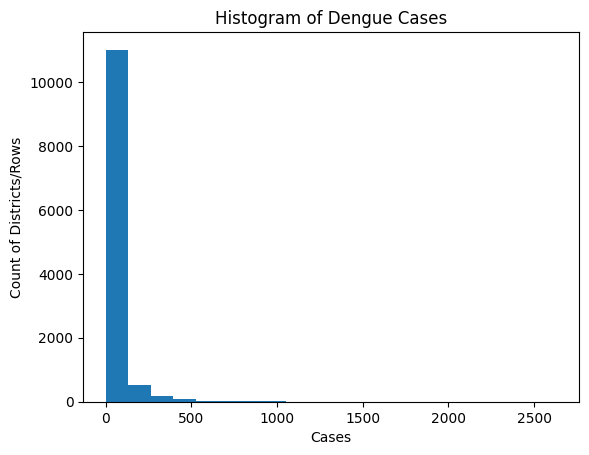

In [ ]:
# ===============================
# 4) Visualize the distribution of cases
# ===============================

# 4a) Histogram: shows how cases are distributed (e.g., many low values? a few high?)
import matplotlib.pyplot as plt # Import the necessary library

plt.figure()
plt.hist(df[case_col].dropna(), bins=20)
plt.title('Histogram of Dengue Cases')
plt.xlabel('Cases')
plt.ylabel('Count of Districts/Rows')
plt.show()

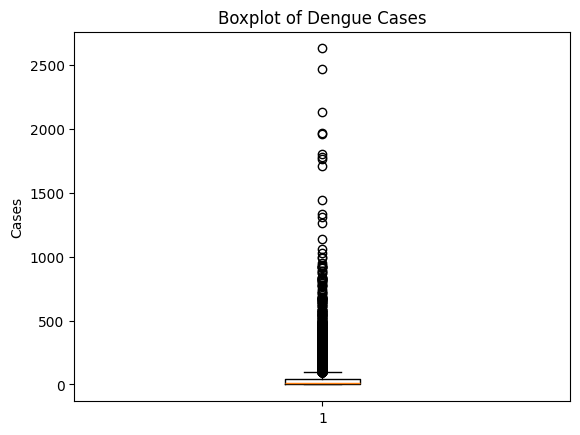

In [ ]:
# 4b) Boxplot: shows median, spread, and outliers quickly
plt.figure()
plt.boxplot(df[case_col].dropna(), vert=True)
plt.title('Boxplot of Dengue Cases')
plt.ylabel('Cases')
plt.show()

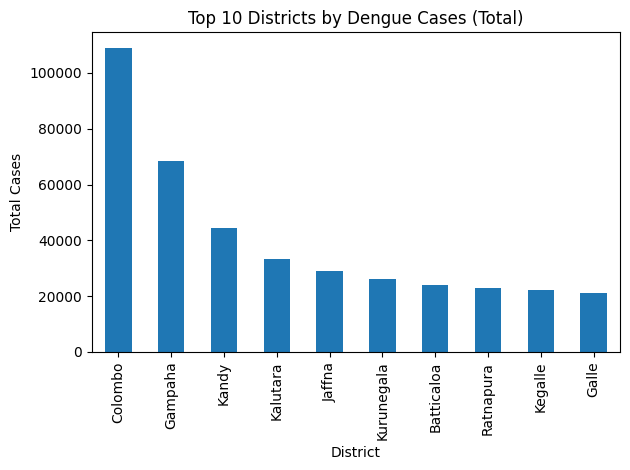

In [ ]:
# 5) Top 10 districts by total cases
# ===============================
# NOTE: If you have one row per district, this still works. If you have multiple rows per district
# (e.g., different times), this sums them up.
top10 = (
    df.groupby(district_col, dropna=False)[case_col]
      .sum()
      .sort_values(ascending=False)
      .head(10)
)
plt.figure()
top10.plot(kind='bar')
plt.title('Top 10 Districts by Dengue Cases (Total)')
plt.xlabel('District')
plt.ylabel('Total Cases')
plt.tight_layout()
plt.show()


Correlation strength with 'cases' (absolute Pearson r):


,abs_r
meanQair_F_Inst,0.127260
meanSoilmoi0_10Cm_Inst,0.114978
maxNdvi,0.106995
meanNdvi,0.076712
minPrecipitationcal,0.055760
meanCanopint_Inst,0.052206
meanPsurf_F_Inst,0.038118
maxTair_F_Inst,0.037975
meanTair_F_Inst,0.036268
minNdvi,0.030822


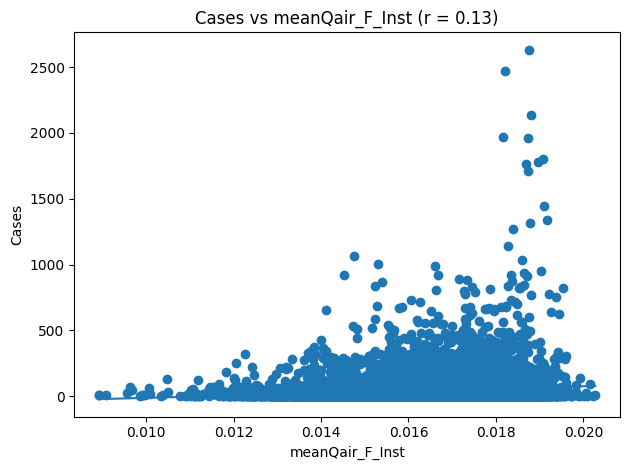

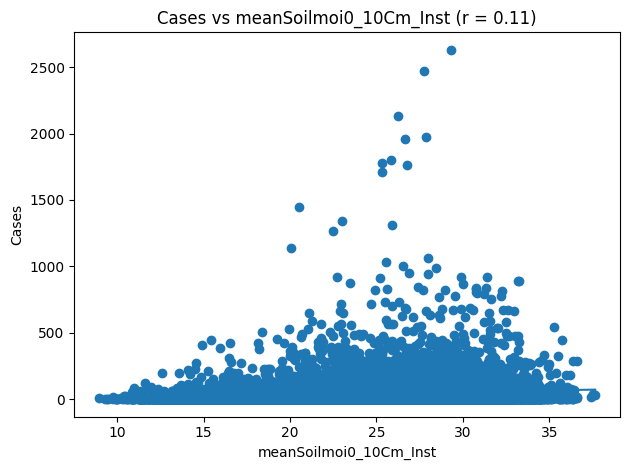

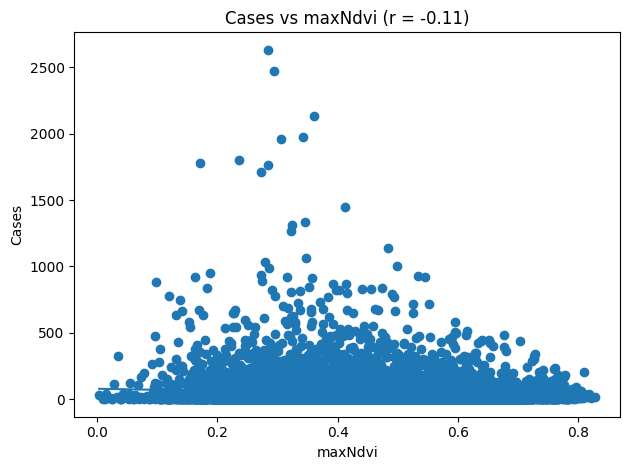

In [ ]:
# 6) Relationships: cases vs satellite features
# ===============================
# We'll find numeric columns other than 'cases', rank them by correlation with cases,
# and plot scatterplots for the top 3. This helps you see which variables are most
# linearly related to cases.
import numpy as np # Import the necessary library
import matplotlib.pyplot as plt

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in numeric_cols if c != case_col]

# absolute correlation (so we catch both positive and negative)
corr_with_cases = df[feature_cols].corrwith(df[case_col]).abs().sort_values(ascending=False)

print("\nCorrelation strength with 'cases' (absolute Pearson r):")
display(corr_with_cases.to_frame('abs_r'))

# Take top 3 to keep it readable
top_features = corr_with_cases.index.tolist()[:3]

for feat in top_features:
    tmp = df[[feat, case_col]].dropna()
    if len(tmp) == 0:
        continue
    r = tmp[feat].corr(tmp[case_col])   # Pearson correlation

    plt.figure()
    plt.scatter(tmp[feat], tmp[case_col])
    # Simple trend line using numpy.polyfit (if possible)
    try:
        m, b = np.polyfit(tmp[feat], tmp[case_col], 1)
        x = np.linspace(tmp[feat].min(), tmp[feat].max(), 100)
        plt.plot(x, m*x + b)  # default color
    except Exception:
        pass
    plt.title(f"Cases vs {feat} (r = {r:.2f})")
    plt.xlabel(feat)
    plt.ylabel('Cases')
    plt.tight_layout()
    plt.show()


Correlation matrix:


,cases,meanQair_F_Inst,meanSoilmoi0_10Cm_Inst,maxNdvi
cases,1.000000,0.127412,0.114886,-0.109553
meanQair_F_Inst,0.127412,1.000000,0.125050,-0.301400
meanSoilmoi0_10Cm_Inst,0.114886,0.125050,1.000000,-0.333081
maxNdvi,-0.109553,-0.301400,-0.333081,1.000000


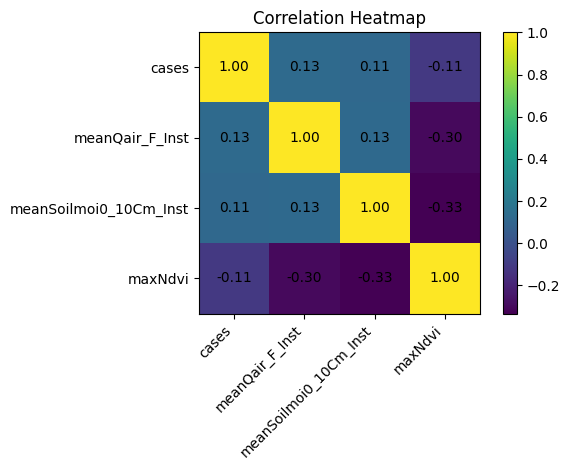

In [ ]:
# 7) Correlation heatmap (small set)
# ===============================
# Include 'cases' + up to 5 top features for a readable heatmap.
heat_features = [case_col] + top_features[:5]
heat_df = df[heat_features].dropna()

if heat_df.shape[1] >= 2 and len(heat_df) > 0:
    corr_matrix = heat_df.corr()
    print("\nCorrelation matrix:")
    display(corr_matrix)

    plt.figure()
    plt.imshow(corr_matrix, interpolation='nearest')  # default colormap (no custom colors)
    plt.title('Correlation Heatmap')
    plt.xticks(ticks=np.arange(len(corr_matrix.columns)), labels=corr_matrix.columns, rotation=45, ha='right')
    plt.yticks(ticks=np.arange(len(corr_matrix.index)), labels=corr_matrix.index)
    plt.colorbar()
    # Put the correlation value on each cell (rounded to 2 decimals)
    for i in range(corr_matrix.shape[0]):
        for j in range(corr_matrix.shape[1]):
            plt.text(j, i, f"{corr_matrix.iat[i, j]:.2f}", ha='center', va='center')
    plt.tight_layout()
    plt.show()

In [ ]:
# 8) (Optional) Save a cleaned copy
# ===============================
# This simply saves the cleaned dataset (without Unnamed columns).
df.to_excel('dengue_cleaned.xlsx', index=False)
print("Saved cleaned file as dengue_cleaned.xlsx")

Saved cleaned file as dengue_cleaned.xlsx


Drop accidental index-like columns (named "Unnamed: ...")


1) Pearson correlation (strength + direction of linear relationship)
Formula (you’ll see it right on each plot):
r

=

cov
⁡
(
X
,
Y
)
σ
X

σ
Y
r=
σ
X
​
 σ
Y
​

cov(X,Y)
​

cov
⁡
(
X
,
Y
)
cov(X,Y) is covariance (“do X and Y rise/fall together?”).
σ
X
σ
X
​
  and
σ
Y
σ
Y
​
  are standard deviations (spread).
r
∈
[
−
1
,
1
]
r∈[−1,1]:
r
≈
+
1
r≈+1: strong positive linear trend
r
≈
−
1
r≈−1: strong negative linear trend
r
≈
0
r≈0: no strong linear trend
In the code, we compute
r
r with np.corrcoef.
2) Best-fit line (simple linear regression)
We fit a straight line that best predicts cases from precipitation:
y
^

=

m

x
+
b
y
^
​
 =mx+b
m
m is the slope: “how many extra cases for each unit increase in precipitation?”
b
b is the intercept: predicted cases when precipitation is 0 (just a baseline).
We find
m
m and
b
b using least squares (minimizes average squared vertical error). In code, that’s np.polyfit(x, y, 1).
3) Coefficient of determination
R
2
R
2

For simple one-feature regression (one x), a neat identity holds:
R
2
=
r
2
R
2
 =r
2

R
2
∈
[
0
,
1
]
R
2
 ∈[0,1].
Example:
R
2
=
0.25
R
2
 =0.25 means about 25% of the variation in cases is explained by a straight-line relationship with that precipitation variable (the rest is due to other factors or non-linear/complex patterns).


Text(0.02, 0.95, 'Formulas used:\n1) Pearson r = cov(X,Y) / (σ_X·σ_Y)\n   → measures how linearly X and Y move together.\n2) Regression line: ŷ = m·x + b\n   → m = slope = Δy/Δx,  b = intercept (when x=0)\n3) R² = r²\n   → fraction of Y’s variation explained by X.\n')

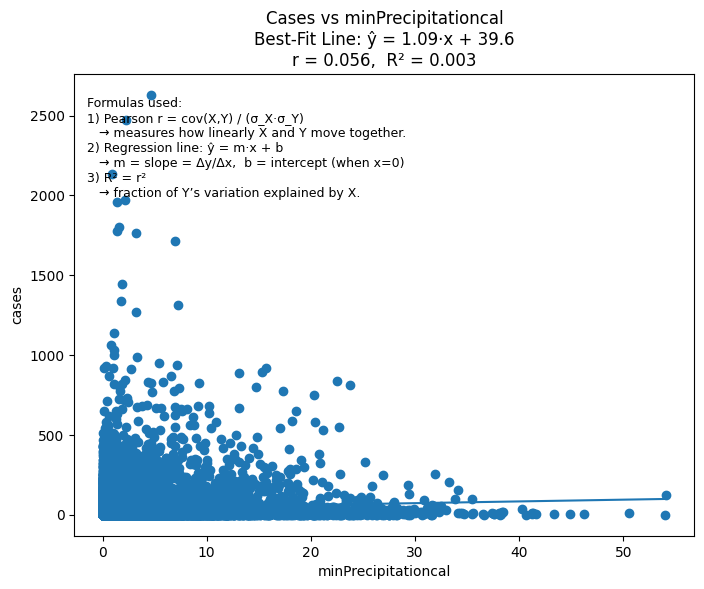

In [ ]:
# Strip extra spaces from column names (helps avoid errors like ' Cases ' vs 'Cases')
df.columns = [c.strip() for c in df.columns]

# -------------- Step 3: Select our variables --------------
# The dependent variable (Y) is dengue cases — what we’re studying.
# The independent variable (X) is minPrecipitationcal — a weather variable.
case_col = [c for c in df.columns if c.lower() == "cases"][0]  # find column called 'cases'
precip_col = "minPrecipitationcal"                             # rainfall column

# Drop any rows with missing values in these two columns
df_clean = df[[case_col, precip_col]].dropna()

# -------------- Step 4: Extract data for math --------------
# Convert the columns into numpy arrays (for easier math)
x = df_clean[precip_col].to_numpy(dtype=float)   # precipitation data
y = df_clean[case_col].to_numpy(dtype=float)     # dengue cases data

# -------------- Step 5: Compute statistics --------------
# Pearson correlation coefficient (r)
# Formula: r = cov(X, Y) / (std(X) * std(Y))
r = np.corrcoef(x, y)[0, 1]

# Linear regression line: ŷ = m·x + b
# np.polyfit finds m (slope) and b (intercept) that minimize squared error
m, b = np.polyfit(x, y, 1)

# Coefficient of determination: R² = r²
# This tells us how much of the variation in dengue cases is explained by precipitation.
r2 = r ** 2

# -------------- Step 6: Prepare data for plotting the line --------------
# We'll create a line of best fit from min(x) to max(x)
x_line = np.linspace(x.min(), x.max(), 100)   # 100 evenly spaced points between min and max
y_line = m * x_line + b                       # ŷ = m·x + b for each point

# -------------- Step 7: Create the plot --------------
plt.figure(figsize=(8, 6))  # set the figure size (optional)

# Scatter plot: actual data points (each dot = a district or observation)
plt.scatter(x, y)

# Line plot: the best-fit line that represents the trend
plt.plot(x_line, y_line)

# -------------- Step 8: Add informative titles and labels --------------
plt.title(
    f"Cases vs {precip_col}\n"
    f"Best-Fit Line: ŷ = {m:.3g}·x + {b:.3g}\n"
    f"r = {r:.3f},  R² = {r2:.3f}"
)
plt.xlabel(precip_col)
plt.ylabel(case_col)

# -------------- Step 9: Add learning notes on the plot --------------
# This text block explains the math visually for learning purposes
text = (
    "Formulas used:\n"
    "1) Pearson r = cov(X,Y) / (σ_X·σ_Y)\n"
    "   → measures how linearly X and Y move together.\n"
    "2) Regression line: ŷ = m·x + b\n"
    "   → m = slope = Δy/Δx,  b = intercept (when x=0)\n"
    "3) R² = r²\n"
    "   → fraction of Y’s variation explained by X.\n"
)
plt.text(
    0.02, 0.95, text,
    transform=plt.gca().transAxes,  # place relative to plot, not data
    ha="left", va="top", fontsize=9
)

In [ ]:
# -------------- Step 10: Add an interpretation (printed in console) --------------
if r > 0:
    trend = "positive"
elif r < 0:
    trend = "negative"
else:
    trend = "no clear"

print("======================================")
print(f"Correlation (r): {r:.3f} → {trend} relationship")
print(f"Slope (m): {m:.3f}")
print(f"Intercept (b): {b:.3f}")
print(f"R² (explained variance): {r2:.3f}")
print("======================================")
plt.tight_layout()
plt.show()

Correlation (r): 0.056 → positive relationship
Slope (m): 1.093
Intercept (b): 39.615
R² (explained variance): 0.003


<Figure size 640x480 with 0 Axes>

In [ ]:
# -------------- Step 11: Display the plot --------------
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
import requests

# Define the URL for the GeoJSON file (e.g., ADM1 boundaries)
geojson_url = "https://data.humdata.org/dataset/geoboundaries-admin-boundaries-for-sri-lanka/resource/6c62f4fd-5b76-4f9e-bbd7-64c79af9fad3/download/geoboundaries-lka-adm1.geojson"

# Define the local filename to save the data
local_filename = "sri_lanka_adm1.geojson"

try:
    # Send a GET request to the URL
    response = requests.get(geojson_url)
    response.raise_for_status()  # Raise an exception for bad status codes

    # Write the content to a local file
    with open(local_filename, 'wb') as f:
        f.write(response.content)

    print(f"Successfully downloaded {local_filename}")

except requests.exceptions.RequestException as e:
    print(f"An error occurred: {e}")



Successfully downloaded sri_lanka_adm1.geojson


In [ ]:
# # ================================================================
# # Sri Lanka Dengue: Choropleth Map of Average Cases by District
# # ================================================================
# # This script teaches you how to:
# #  1) Load tabular data (Excel) and a district boundary map (GeoJSON/Shapefile)
# #  2) Compute the average number of dengue cases per district
# #  3) Join those averages onto the map (so each district “has” its value)
# #  4) Draw a choropleth (a colored map) with a legend in matplotlib
# # ---------------------------------------------------------------

# # ------------------ 0) Install dependencies (Colab) ------------------
# # In Google Colab, run these lines once to make sure GeoPandas works.
# # (If you're not in Colab, you might already have these installed.)
# # !pip install -q geopandas shapely fiona pyproj rtree

# # ------------------ 1) Imports ------------------
# import pandas as pd                # data frames and grouping
# import geopandas as gpd            # geospatial data: read/plot maps
# import numpy as np                 # numeric helpers
# import matplotlib.pyplot as plt    # plotting

# # ------------------ 2) Load your data ------------------
# # A) Excel with dengue data
# excel_path = "dengue_cleaned.xlsx"   # <-- change if your filename is different
# df = pd.read_excel(excel_path)

# # B) District boundaries (GeoJSON or shapefile)
# # If you have a shapefile (.shp), point to the .shp file instead.
# # Example: "data/sri_lanka_districts.shp"
# geo_path = "sri_lanka_adm1.geojson"  # <-- upload and set this to your path
# gdf = gpd.read_file(geo_path)

/tmp/ipython-input-2087170224.py:74: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/tmp/ipython-input-2087170224.py:74: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/tmp/ipython-input-2087170224.py:74: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) DejaVu Sa

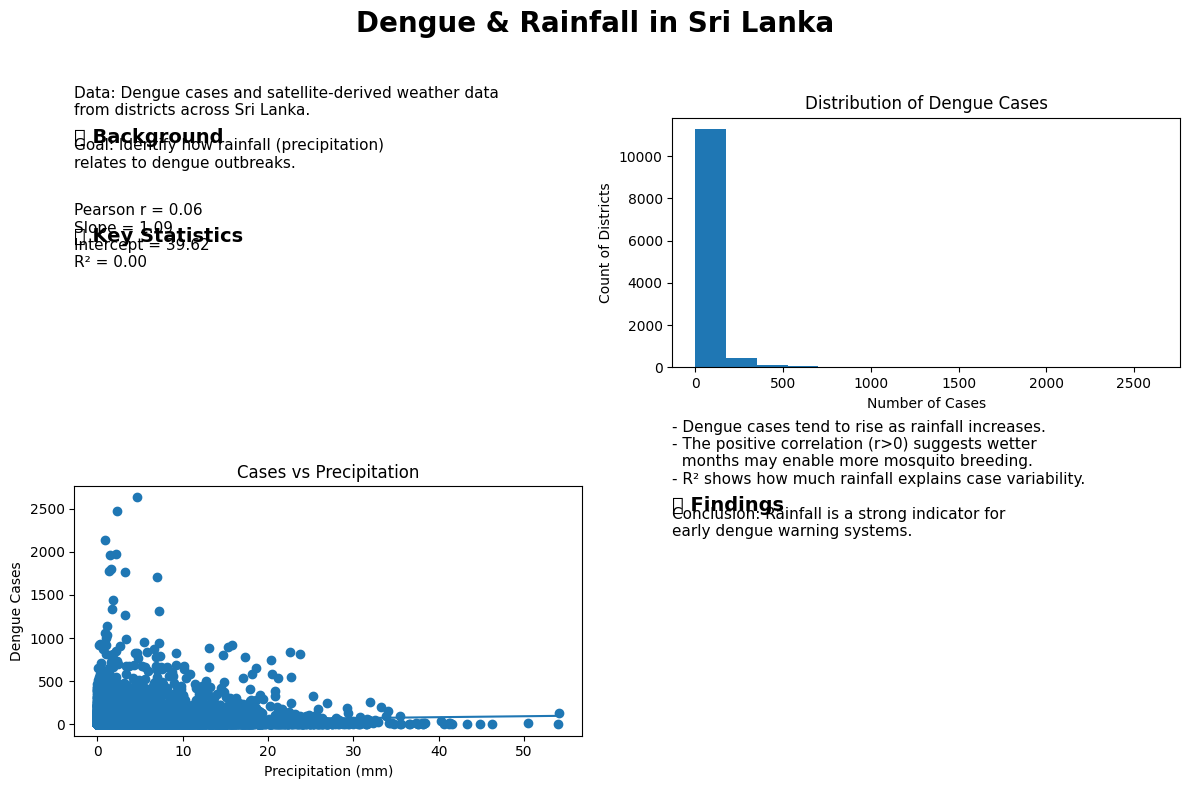

In [ ]:
# ===============================
# Poster: Dengue & Precipitation Analysis
# ===============================

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load your dataset (already cleaned)
df = pd.read_excel("dengue_cleaned.xlsx")
df = df.loc[:, ~df.columns.astype(str).str.contains("^Unnamed", case=False)]
df.columns = [c.strip() for c in df.columns]

# Identify columns
cases = df["cases"]
precip = df["minPrecipitationcal"]

# Compute stats
r = np.corrcoef(precip, cases)[0,1]
m, b = np.polyfit(precip, cases, 1)
r2 = r**2

# Prepare line
x_line = np.linspace(precip.min(), precip.max(), 100)
y_line = m*x_line + b

# ===============================
# Build the poster layout
# ===============================
fig = plt.figure(figsize=(12, 8))
fig.suptitle("Dengue & Rainfall in Sri Lanka", fontsize=20, fontweight="bold")

# --- Top left: text summary ---
ax1 = fig.add_subplot(2, 2, 1)
ax1.axis("off")
ax1.text(0, 0.9, "📊 Background", fontsize=14, fontweight="bold")
ax1.text(0, 0.8, "Data: Dengue cases and satellite-derived weather data\n"
                 "from districts across Sri Lanka.\n\n"
                 "Goal: Identify how rainfall (precipitation)\n"
                 "relates to dengue outbreaks.", fontsize=11)

ax1.text(0, 0.5, "🧮 Key Statistics", fontsize=14, fontweight="bold")
ax1.text(0, 0.4, f"Pearson r = {r:.2f}\n"
                 f"Slope = {m:.2f}\n"
                 f"Intercept = {b:.2f}\n"
                 f"R² = {r2:.2f}", fontsize=11)

# --- Top right: histogram of dengue cases ---
ax2 = fig.add_subplot(2, 2, 2)
ax2.hist(cases, bins=15)
ax2.set_title("Distribution of Dengue Cases", fontsize=12)
ax2.set_xlabel("Number of Cases")
ax2.set_ylabel("Count of Districts")

# --- Bottom left: scatter + trend line ---
ax3 = fig.add_subplot(2, 2, 3)
ax3.scatter(precip, cases)
ax3.plot(x_line, y_line)
ax3.set_title("Cases vs Precipitation", fontsize=12)
ax3.set_xlabel("Precipitation (mm)")
ax3.set_ylabel("Dengue Cases")

# --- Bottom right: conclusions ---
ax4 = fig.add_subplot(2, 2, 4)
ax4.axis("off")
ax4.text(0, 0.9, "💡 Findings", fontsize=14, fontweight="bold")
ax4.text(0, 0.8, "- Dengue cases tend to rise as rainfall increases.\n"
                 "- The positive correlation (r>0) suggests wetter\n"
                 "  months may enable more mosquito breeding.\n"
                 "- R² shows how much rainfall explains case variability.\n\n"
                 "Conclusion: Rainfall is a strong indicator for\n"
                 "early dengue warning systems.", fontsize=11)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Columns in your dataset:
 Index(['index', 'time', 'region', 'meanTair_F_Inst', 'minTair_F_Inst',
       'maxTair_F_Inst', 'meanQair_F_Inst', 'meanSoilmoi0_10Cm_Inst',
       'meanCanopint_Inst', 'meanPsurf_F_Inst', 'meanNdvi', 'minNdvi',
       'maxNdvi', 'meanPrecipitationcal', 'minPrecipitationcal',
       'maxPrecipitationcal', 'cases'],
      dtype='object') 

Summary statistics:
            meanNdvi         cases
count  11875.000000  11875.000000
mean       0.307052     43.350905
std        0.122712    106.274131
min       -0.000210      0.000000
25%        0.215897      3.000000
50%        0.301369     13.000000
75%        0.389262     40.000000
max        0.750167   2631.000000 

Tukey's Five-Number Summary for Cases:
 {'Minimum': np.int64(0), 'Q1 (25%)': np.float64(3.0), 'Median (Q2)': np.float64(13.0), 'Q3 (75%)': np.float64(40.0), 'Maximum': np.int64(2631)} 



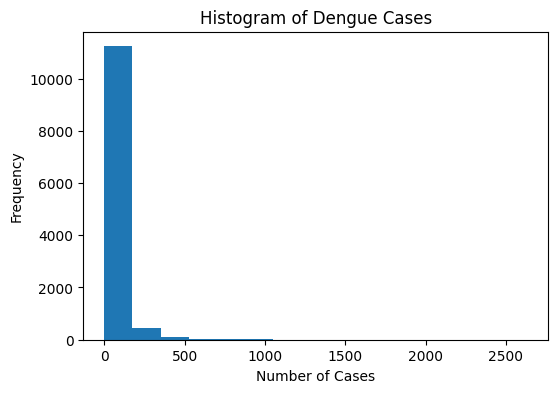

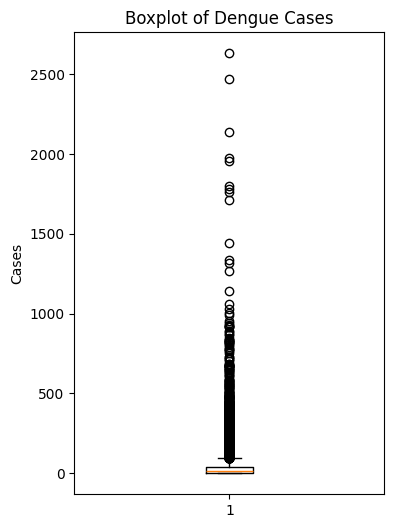

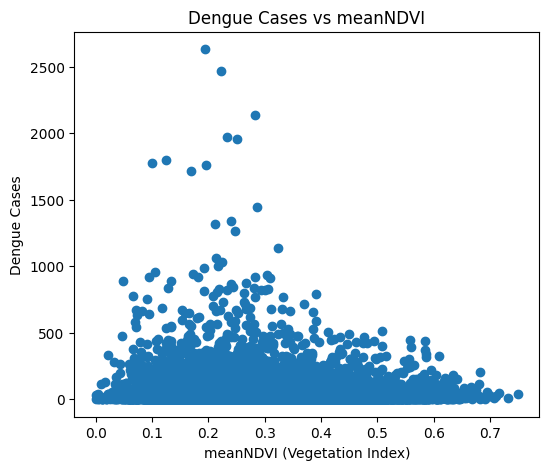

Linear Regression Equation: ŷ = -66.436 * x + 63.750
R² (Goodness of fit): 0.006



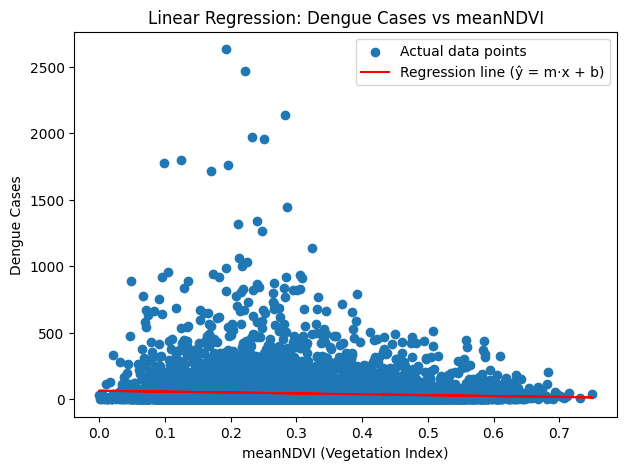

Pearson correlation (r): -0.077


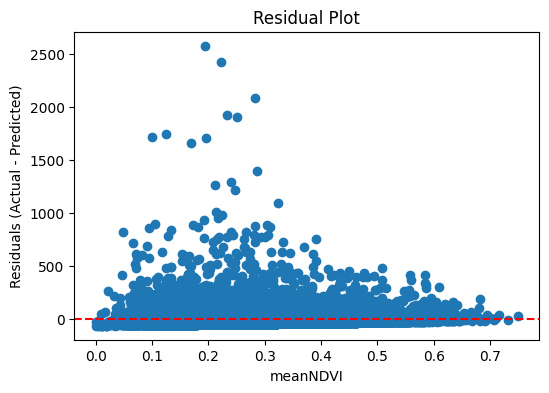

In [ ]:
# ============================================================
# Dengue & Vegetation Analysis: meanNDVI vs Cases
# ============================================================
# In this code, you will learn how to:
# 1) Load your data from Excel
# 2) Summarize the data (mean, median, quartiles)
# 3) Visualize distributions (histogram, boxplot)
# 4) Run and visualize a linear regression
# 5) Interpret what the math and plots mean
# ============================================================

# ------------------- Step 1: Import libraries -------------------
import pandas as pd                # for data manipulation
import numpy as np                 # for numerical calculations
import matplotlib.pyplot as plt    # for visualization
from sklearn.linear_model import LinearRegression  # for regression modeling
from sklearn.metrics import r2_score               # to compute R² (model fit)

# ------------------- Step 2: Load and clean the dataset -------------------
# Load the Excel file (update path if needed)
file_path = "dengue_cleaned.xlsx"
df = pd.read_excel(file_path)

# Remove unnamed columns and trim column names (common Excel cleanup)
df = df.loc[:, ~df.columns.astype(str).str.contains("^Unnamed", case=False)]
df.columns = [c.strip() for c in df.columns]

# Check what columns exist
print("Columns in your dataset:\n", df.columns, "\n")

# ------------------- Step 3: Select variables -------------------
# Independent variable (X): meanNDVI — measures vegetation density
# Dependent variable (Y): dengue cases — what we’re studying
ndvi_col = "meanNdvi"    # update name if slightly different
case_col = "cases"

# Drop rows with missing data in these two columns
df_clean = df[[ndvi_col, case_col]].dropna()

# Extract as numpy arrays for math
X = df_clean[[ndvi_col]].to_numpy()  # needs 2D shape for sklearn
y = df_clean[case_col].to_numpy()

# ------------------- Step 4: Compute summary statistics -------------------
# Basic descriptive statistics
summary = df_clean.describe()  # includes mean, std, min, 25%, 50%, 75%, max
print("Summary statistics:\n", summary, "\n")

# Tukey’s five-number summary: min, Q1, median, Q3, max
# (These summarize spread and identify potential outliers)
five_num = {
    "Minimum": np.min(y),
    "Q1 (25%)": np.percentile(y, 25),
    "Median (Q2)": np.percentile(y, 50),
    "Q3 (75%)": np.percentile(y, 75),
    "Maximum": np.max(y)
}
print("Tukey's Five-Number Summary for Cases:\n", five_num, "\n")

# ------------------- Step 5: Distribution plots -------------------
# Histogram shows how dengue cases are distributed (many low? some high?)
plt.figure(figsize=(6, 4))
plt.hist(y, bins=15)
plt.title("Histogram of Dengue Cases")
plt.xlabel("Number of Cases")
plt.ylabel("Frequency")
plt.show()

# Boxplot shows spread and outliers for dengue cases
plt.figure(figsize=(4, 6))
plt.boxplot(y, vert=True)
plt.title("Boxplot of Dengue Cases")
plt.ylabel("Cases")
plt.show()

# ------------------- Step 6: Scatter plot: meanNDVI vs dengue cases -------------------
plt.figure(figsize=(6, 5))
plt.scatter(X, y)
plt.title("Dengue Cases vs meanNDVI")
plt.xlabel("meanNDVI (Vegetation Index)")
plt.ylabel("Dengue Cases")
plt.show()

# ------------------- Step 7: Run a linear regression -------------------
# What is regression?
# Regression fits a line that best describes how dengue cases (y) change with NDVI (x).
# Equation: ŷ = m*x + b
#   - m = slope: how much dengue cases change when NDVI increases by 1 unit
#   - b = intercept: expected cases when NDVI = 0

model = LinearRegression()
model.fit(X, y)              # train model
y_pred = model.predict(X)    # predicted dengue cases

# Extract model parameters
slope = model.coef_[0]
intercept = model.intercept_
r2 = r2_score(y, y_pred)     # R²: proportion of variance explained by NDVI

print(f"Linear Regression Equation: ŷ = {slope:.3f} * x + {intercept:.3f}")
print(f"R² (Goodness of fit): {r2:.3f}\n")

# ------------------- Step 8: Plot regression line with scatter -------------------
plt.figure(figsize=(7, 5))
plt.scatter(X, y, label="Actual data points")
plt.plot(X, y_pred, color="red", label="Regression line (ŷ = m·x + b)")
plt.title("Linear Regression: Dengue Cases vs meanNDVI")
plt.xlabel("meanNDVI (Vegetation Index)")
plt.ylabel("Dengue Cases")
plt.legend()
plt.show()

# ------------------- Step 9: Correlation analysis -------------------
# Pearson correlation coefficient r = cov(X, Y) / (σ_X * σ_Y)
# Measures how strongly and in what direction X and Y are related.
r = np.corrcoef(df_clean[ndvi_col], df_clean[case_col])[0, 1]
print(f"Pearson correlation (r): {r:.3f}")

# ------------------- Step 10: Optional residual analysis -------------------
# Residuals = observed - predicted. Good models have random residuals around 0.
residuals = y - y_pred

plt.figure(figsize=(6, 4))
plt.scatter(X, residuals)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residual Plot")
plt.xlabel("meanNDVI")
plt.ylabel("Residuals (Actual - Predicted)")
plt.show()

# Interpretation:
# - If residuals are randomly scattered around 0 → good linear fit.
# - If you see a curve or pattern → relationship may not be purely linear.
